In [1]:
import nibabel as nib
import numpy as np
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.padding import PKCS7
import os
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
import logging
from nibabel.filebasedimages import FileBasedImage
import cv2
import pandas as pd
import kagglehub
from pyspark.rdd import RDD
import boto3
from io import BytesIO
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger(__name__)

In [2]:
from dotenv import load_dotenv

CT_SCANS = "../rawdata/ct_scans"
INFECTION_MASKS = "../rawdata/infection_mask"
LUNGANDINFECTION_MASKS = "../rawdata/lung_and_infection_mask"
LUNG_MASKS = "../rawdata/lung_mask"
OUTPUT_DIR = "../rawdata/"

# Load environment variables
load_dotenv()
# Load Minio credentials
S3_ACCESS_KEY = os.getenv("S3_ACCESS_KEY")
S3_SECRET_KEY = os.getenv("S3_SECRET_KEY")
print(S3_ACCESS_KEY)
print(S3_SECRET_KEY)

o1Qzq9W0RuSODfOdOWMO
NvuyLbJngKDNtNf0GdllPvbtZk3Wgg2SbgOaIqLF


In [3]:
spark = SparkSession.builder \
    .appName("NIfTI_Processing") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.maxResultSize", "10g") \
    .getOrCreate()
    # .config("spark.hadoop.fs.s3a.access.key", S3_ACCESS_KEY) \
    # .config("spark.hadoop.fs.s3a.secret.key", S3_SECRET_KEY) \
    # .config("spark.hadoop.fs.s3a.endpoint", "https://s3.captechvn.com") \
    # .config("fs.s3a.connection.ssl.enabled", "true") \
    # .config("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    # .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    # .config("fs.s3a.connection.timeout", "600000") \
sc = spark.sparkContext

24/12/19 13:39:16 WARN Utils: Your hostname, SerVer resolves to a loopback address: 127.0.1.1; using 192.168.1.250 instead (on interface enp3s0f0)
24/12/19 13:39:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/19 13:39:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load into RDDs

In [4]:
##### Extract #####
def download_data():
    if os.path.exists(OUTPUT_DIR):
        return
    os.makedirs("OUTPUT_DIR", exist_ok=True)
    # Download latest version to rawdata folder
    path = kagglehub.dataset_download("andrewmvd/covid19-ct-scans")
    print("Path to dataset files:", path)
    # Move the downloaded folder to the rawdata directory, For example: 4/ct_scans, 4/metadata -> rawdata/ct_scans, rawdata/metadata
    os.rename(path, OUTPUT_DIR)
    print("Data downloaded and unzipped successfully!")

def extract_metadata():
    # Extract metadata from the downloaded dataset
    path = os.path.join(OUTPUT_DIR, "metadata.csv")
    metadata = pd.read_csv(path)
    logger.info("Metadata extracted successfully!")
    metadata.replace("../input/covid19-ct-scans/", "", regex=True, inplace=True)
    return metadata

def extract_image_data(metadata: pd.DataFrame) -> RDD:
    # Convert DataFrame to np array
    image_paths: np.ndarray = metadata.to_numpy().flatten()
    # Extract image data
    def load_image(x):
        path = os.path.join(OUTPUT_DIR, x)
        nifti_data = nib.load(path)
        header = nifti_data.header
        affine = nifti_data.affine
        image_data = nifti_data.get_fdata()
        image_data = np.array(image_data)

        return image_data, header, affine, x

    image_rdds = sc.parallelize(image_paths).map(load_image)

    return image_rdds

In [5]:
##### Transform #####

# Resize the image's x and y dimensions to 256x256
def resize_image(image_rdds: RDD):
    def resize_image(x):
        image_data, header, affine, file_name = x
        resized_image = cv2.resize(image_data, (256, 256))
        return resized_image, header, affine, file_name
    
    resized_image_rdds = image_rdds.map(resize_image)
    logger.info("Image resized successfully!")
    return resized_image_rdds

# Normalize the image data
def normalize_image(image_rdds: RDD):
    def normalize_image(x):
        image_data, header, affine, file_name = x
        normalized_image = cv2.normalize(image_data, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        return normalized_image, header, affine, file_name

    normalized_image_rdds = image_rdds.map(normalize_image)
    logger.info("Image normalized successfully!")
    return normalized_image_rdds

# Noice reduction
def denoise_image(image_rdds: RDD):
    def denoise_image(x):
        image_data, header, affine, file_name = x
        denoised_image = cv2.fastNlMeansDenoising(image_data, None, 10, 7, 21)
        return denoised_image, header, affine, file_name

    denoised_image_rdds = image_rdds.map(denoise_image)
    logger.info("Image denoised successfully!")
    return denoised_image_rdds

# Encrypt the image data
def encrypt_image(image_rdds: RDD, password: str):
    def encrypt_image_record(record):
        """
        Encrypts a single image record.

        Args:
            record (tuple): A tuple containing (image_data, header, affine, file_name)

        Returns:
            tuple: A tuple containing (encrypted_data, header, affine, file_name)
        """
        # Sinh salt và vector khởi tạo (IV)
        salt = os.urandom(16)  # Tạo salt ngẫu nhiên
        iv = os.urandom(16)    # Tạo vector khởi tạo (IV) ngẫu nhiên

        from cryptography.hazmat.primitives.ciphers import algorithms  # Import locally to avoid pickling issues

        # Tạo khóa mã hóa từ mật khẩu
        kdf = PBKDF2HMAC(
            algorithm=hashes.SHA256(),
            length=32,
            salt=salt,
            iterations=100000,
            backend=default_backend()
        )
        key = kdf.derive(password.encode())  # Tạo khóa từ mật khẩu
        cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())

        image_data: np.ndarray
        image_data, header, affine, file_name = record

        # Lưu kích thước ảnh gốc
        original_shape = image_data.shape
        # Chuyển ảnh thành dạng bytes
        data_bytes = image_data.tobytes()
        # Padding dữ liệu để đảm bảo đúng kích thước khối (block size) của AES
        padder = PKCS7(algorithms.AES.block_size).padder()
        padded_data = padder.update(data_bytes) + padder.finalize()
        encryptor = cipher.encryptor()
        encrypted_data = encryptor.update(padded_data) + encryptor.finalize()

        return encrypted_data, salt, iv, original_shape, file_name

    encrypted_image_rdds = image_rdds.map(encrypt_image_record)
    logger.info("Image encrypted successfully!")
    return encrypted_image_rdds


In [8]:
##### Load #####
# Save to disk
def save_data(image_rdds: RDD):
    def save_image(x):
        encrypted_bytes, header, affine, file_name = x
        print(f"Saving image: {file_name}")
        # Save image data: np array to disk
        os.makedirs("output", exist_ok=True)
        folder = file_name.split("/")[0]
        os.makedirs(f"output/{folder}", exist_ok=True)
        with open(f"output/{file_name}.npy", "wb") as f:
            f.write(encrypted_bytes)
        print(f"Saved image: {file_name}")

    image_rdds.foreach(save_image)

# Save to minio bucket
def save_to_bucket(image_rdds: RDD):
    # Save image data to minio bucket: https://s3.captechvn.com/etl-mi
    def upload_numpy_to_minio(x):
        s3_client = boto3.client(
            "s3",
            aws_access_key_id=S3_ACCESS_KEY,
            aws_secret_access_key=S3_SECRET_KEY,
            endpoint_url="https://s3.captechvn.com",
            verify=False
        )
        try:
            # Save NumPy array to memory
            # image_data, header, affine, file_name = x
            # buffer = BytesIO()
            # np.save(buffer, image_data)

            # Save encrypted image data to memory
            encrypted_bytes, salt, iv, original_shape, file_name = x
            file_name += ".enc"
            
            buffer = BytesIO()
            buffer.write(salt)  # Write salt
            buffer.write(iv)    # Write IV
            # Write original shape (as int32)
            buffer.write(np.array(original_shape, dtype=np.int32).tobytes())
            buffer.write(encrypted_bytes)  # Write encrypted data
            buffer.seek(0)  # Reset buffer position to the beginning
            # Upload to MinIO
            s3_client.put_object(
                Bucket="etl-mi",
                Key=file_name,
                Body=buffer.getvalue(),
                ContentType="application/octet-stream"
            )

            print(f"Uploaded {file_name} to MinIO")
        except Exception as e:
            print(f"Error uploading {file_name}: {e}")

    image_rdds.foreach(upload_numpy_to_minio)
    logger.info("Image saved to minio bucket successfully!")

In [9]:
download_data()
metadata = extract_metadata()
rdds = extract_image_data(metadata)
rdds = resize_image(rdds)
rdds = normalize_image(rdds)
encrypted = encrypt_image(rdds, "password")
save_to_bucket(encrypted)
# save_data(encrypted)
# save_encrypted_image(encrypted)

INFO:__main__:Metadata extracted successfully!
INFO:__main__:Image resized successfully!
INFO:__main__:Image normalized successfully!
INFO:__main__:Image encrypted successfully!
Traceback (most recent call last):
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/serializers.py", line 459, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/cloudpickle/cloudpickle_fast.py", line 73, in dumps
    cp.dump(obj)
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/cloudpickle/cloudpickle_fast.py", line 632, in dump
    return Pickler.dump(self, obj)
           ^^^^^^^^^^^^^^^^^^^^^^^
TypeError: cannot pickle '_ModuleWithDeprecations' object


PicklingError: Could not serialize object: TypeError: cannot pickle '_ModuleWithDeprecations' object

In [9]:
# Load a sample from the saved data
loaded_data = np.load("coronacases_org_001.nii.npy")
import matplotlib.pyplot as plt

middle_slice = loaded_data.shape[2] // 2
plt.imshow(loaded_data[:,:,middle_slice], cmap="gray")
plt.axis("off")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'coronacases_org_001.nii.npy'

In [16]:
def decrypt_image(file_path: str):
    s3 = boto3.client(
        "s3",
        aws_access_key_id=S3_ACCESS_KEY,
        aws_secret_access_key=S3_SECRET_KEY,
        endpoint_url="https://s3.captechvn.com",
    )
    backend = default_backend()
    salt = b"this is a salt"
    password = b"123123"
    kdf = PBKDF2HMAC(
        algorithm=hashes.SHA256(),
        length=32,
        salt=salt,
        iterations=100000,
        backend=backend
    )
    key = kdf.derive(password)
    response = s3.get_object(Bucket="etl-mi", Key=file_path)
    encrypted_data = response["Body"].read()
    # Extract nonce and ciphertext
    nonce = encrypted_data[:16]
    ct = encrypted_data[16:]
    cipher = Cipher(algorithms.AES(key), modes.CTR(nonce), backend=backend)
    decryptor = cipher.decryptor()
    decrypted_bytes = decryptor.update(ct) + decryptor.finalize()
    # Convert bytes back to original image data format
    # You need to know the original dtype and shape; replace <dtype> and <shape> accordingly
    image_data = np.frombuffer(decrypted_bytes, dtype=np.uint8)  # Example dtype
    # Reshape so that the first 2 dimension is 218x128
    image_data = image_data.reshape((256, 256, -1))  # Example shape
    return image_data

In [ ]:
result = decrypt_image("ct_scans/coronacases_org_001.nii.enc")
from matplotlib import pyplot as plt

NameError: name 'middle_slice' is not defined

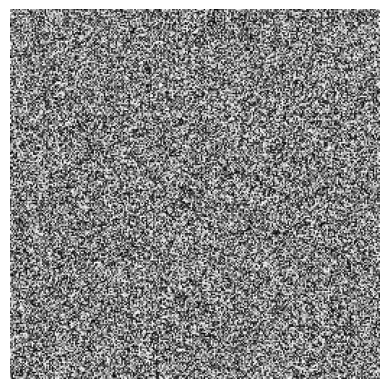

In [20]:
plt.imshow(result[:,:,0], cmap="gray")
plt.axis("off")

plt.show()

## Encrypted Data